<a href="https://colab.research.google.com/github/stevensmiley1989/TensorFlow_Examples/blob/main/TF_CNN_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Purpose
The purpose of this notebook is to use Transfer Learning with TensorFlow for prediction with cats vs. dogs dataset.

# 2.0 Import Libraries

In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

# 3.0 Import Cats_vs_Dogs dataset from Kaggle

## 3.0.1 [Find your Kaggle Account and click the **Create New API Token** to download the json file](https://www.kaggle.com/stevensmiley/account?isEditing=False)

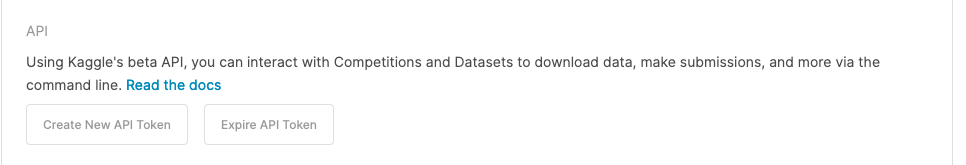

## 3.0.2 **Upload** kaggle.json file

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


## 3.0.3 Pick the **kaggle.json** file from your Kaggle download

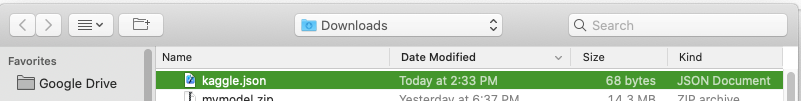

## 3.0.4 install kaggle with pip

In [3]:
! pip install -q kaggle

## 3.0.5 create kaggle directory

In [4]:
! mkdir ~/.kaggle 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## 3.0.6 copy the kaggle.json file to the kaggle directory

In [5]:
! cp kaggle.json ~/.kaggle/

## 3.0.7 Set 600 permissions to a kaggle.json file so you (owner) has full read and write access to the file, while no other user can access the file.

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

## 3.0.8 List the kaggle datasets

In [7]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-06-01 11:18:46           6765  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           4016  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1353  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           2111  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

## 3.0.9 download the dogs-vs-cats dataset

In [8]:
!kaggle competitions download -c dogs-vs-cats

train.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)


## 3.0.9 Create **train** directory

In [9]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


## 3.0.10 Create **test** directory

In [10]:
! mkdir test

mkdir: cannot create directory ‘test’: File exists


## 3.0.11 **new_dir** 
helper function for making directories

In [11]:
def new_dir(path):
  try:
    os.mkdir(path)
  except:
    print(f'Already have: {path}')
    pass

## 3.0.12 get_training_metrics
helper function for getting history metrics

In [12]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['binary_accuracy']
  val_acc = history['val_binary_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

## 3.0.13 plot_train_eval
helper function for plotting history metrics

In [13]:
def plot_train_eval(history,name='',parameters='',num_images_per_epoch_train='',num_images_per_epoch_val='',batch_size='',pre_trained_model_name='',
last_layer_pretrained_name=''):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title(f'training vs evaluation accuracy: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size} \n pre_trained_model_name={pre_trained_model_name} \n last_layer_pretrained_name={last_layer_pretrained_name}')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('binary_crossentropy')
  plt.savefig(f'{name} - train_acc_vs_eval_acc.jpg',bbox_inches='tight')
  plt.show()


  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title(f'training vs evaluation loss: {name} \n # parameters={parameters} \n num_images_per_epoch_train={num_images_per_epoch_train} \n num_images_per_epoch_val={num_images_per_epoch_val} \n batch_size={batch_size} \n pre_trained_model_name={pre_trained_model_name} \n last_layer_pretrained_name={last_layer_pretrained_name}')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.savefig(f'{name} - train_loss_vs_eval_loss.jpg',bbox_inches='tight')
  plt.show()






## 3.0.14 ImageGenerator
helper function for generating augmentented images

In [14]:
def ImageGenerator(X_train1,save_here='',id=''):
    from keras.preprocessing.image import ImageDataGenerator
    import random
    X_train1_e=X_train1

    seed=1

    datagenX = ImageDataGenerator(rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

    # prepare iterator
    datagenX.fit(X_train1_e,seed=seed)
    Xflow = datagenX.flow(X_train1_e,
                         batch_size=X_train1_e.shape[0]*2,seed=seed,shuffle=False,save_to_dir=save_here,     #this is where we figure out where to save
         save_prefix=f'aug-{id}-',        # it will save the images as 'aug_XXX' some number for every new augmented image
        save_format='jpg')


    t_x=Xflow.next()

    
    return np.squeeze(t_x)

In [15]:
cols=['filename','model_name',
      'optimizer',
      'loss',
      'accuracy_metric',
      'batch_size','img_size',
      'steps_per_epoch','epochs','validation_steps',
      'num_images_per_epoch_train','num_images_per_epoch_val',
      'data_augmentation',
      'F1_score_dog','F1_score_cat',
      'Precision_dog','Precision_cat',
      'Recall_dog','Recall_cat',
      'misclassified_dogs','misclassified_cats',
      'pre_trained_model_name',
'last_layer_pretrained_name']
df_metrics=pd.DataFrame(columns=cols)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats,pre_trained_model_name,last_layer_pretrained_name


# 4.0 model1

In [16]:
filename='TF_CNN_TransferLearning.ipynb'
model_name='model1'
optimizer=RMSprop(lr=0.0001)
optimizer_name=str(optimizer)
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=20
img_size=150
steps_per_epoch=100
epochs=20
validation_steps=100
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation='True_Transform_All_Training_Images, Keep Same Total Training Images'
pre_trained_model_name='InceptionV3'
last_layer_pretrained_name='mixed6'

num_images_per_epoch_train:  2000
num_images_per_epoch_val:  2000


## Create **train_1** train & eval images

In [17]:
! rm -r /content/train_1
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Download Model

In [18]:
if pre_trained_model_name=='InceptionV3':
  pre_trained_model=tf.keras.applications.inception_v3.InceptionV3(
      input_shape=(img_size,img_size,3),
      include_top=False,
      weights="imagenet",
  )


In [19]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [20]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Set Last Layer to Transfer Learn from

In [21]:
print(last_layer_pretrained_name)
last_layer=pre_trained_model.get_layer(last_layer_pretrained_name)

mixed6


In [22]:
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [23]:
last_output=last_layer.output

## Add Custom Classifier Layers

In [24]:


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = optimizer, 
              loss = loss, 
              metrics = [accuracy_metric])


In [25]:
train_dir = '/content/train_1/train/'
validation_dir = '/content/train_1/eval/'
train_cats_dir='/content/train_1/train/cat/'
validation_cats_dir='/content/train_1/eval/cat/'
train_dogs_dir='/content/train_1/train/dog/'
validation_dogs_dir='/content/train_1/eval/dog/'

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
if data_augmentation=='True_Transform_All_Training_Images, Keep Same Total Training Images':
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
else:
  train_datagen=ImageDataGenerator(rescale=1.0/255.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = (img_size, img_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_size, img_size))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Train Model

In [26]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = epochs,
            validation_steps = validation_steps)

Epoch 1/20
100/100 [==============================] - 24s 197ms/step - loss: 0.8594 - binary_accuracy: 0.6950 - val_loss: 0.4005 - val_binary_accuracy: 0.8145
Epoch 2/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3916 - binary_accuracy: 0.8395 - val_loss: 0.2538 - val_binary_accuracy: 0.9025
Epoch 3/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3827 - binary_accuracy: 0.8420 - val_loss: 0.1886 - val_binary_accuracy: 0.9255
Epoch 4/20
100/100 [==============================] - 18s 185ms/step - loss: 0.3462 - binary_accuracy: 0.8485 - val_loss: 0.1711 - val_binary_accuracy: 0.9295
Epoch 5/20
100/100 [==============================] - 18s 185ms/step - loss: 0.3453 - binary_accuracy: 0.8615 - val_loss: 0.2773 - val_binary_accuracy: 0.9000
Epoch 6/20
100/100 [==============================] - 18s 184ms/step - loss: 0.2949 - binary_accuracy: 0.8810 - val_loss: 0.2005 - val_binary_accuracy: 0.9235
Epoch 7/20
100/100 [==========================

## Evaluate **model**

In [27]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

38537217

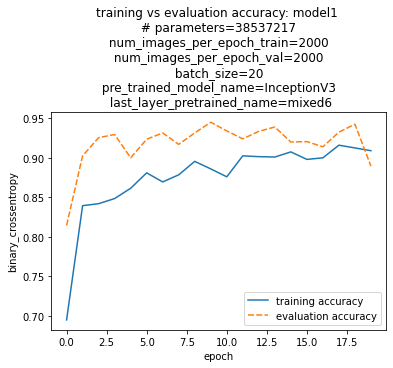

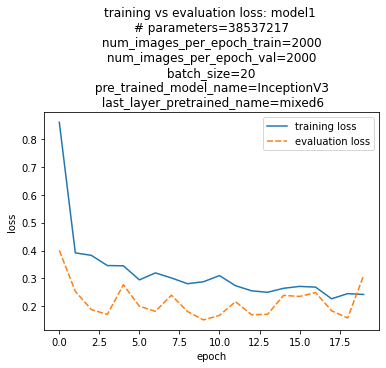

In [28]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size,
                pre_trained_model_name=pre_trained_model_name,
                last_layer_pretrained_name=last_layer_pretrained_name)

In [29]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [30]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")

Accuracy Score: 0.8924
Balanced Accuracy Score: 0.8924


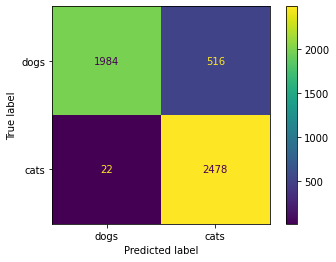

In [31]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [32]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [33]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [34]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 0.88%
Proportion of misclassified dogs: 20.64%


In [35]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats,
                  pre_trained_model_name,
                  last_layer_pretrained_name
                  ]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats,pre_trained_model_name,last_layer_pretrained_name
0,TF_CNN_TransferLearning.ipynb,model1,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,"True_Transform_All_Training_Images, Keep Same ...",0.880604,0.902075,0.7936,0.9912,0.989033,0.827655,0.2064,0.0088,InceptionV3,mixed6


In [36]:
model.save(model_name) #save model
model=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model1/assets


# 5.0 model2

In [37]:
filename='TF_CNN_TransferLearning.ipynb'
model_name='model2'
optimizer=RMSprop(lr=0.0001)
optimizer_name=str(optimizer)
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=20
img_size=150
steps_per_epoch=100
epochs=20
validation_steps=100
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=False
pre_trained_model_name='InceptionV3'
last_layer_pretrained_name='mixed6'

num_images_per_epoch_train:  2000
num_images_per_epoch_val:  2000


## Create **train_1** train & eval images

In [38]:
! rm -r /content/train_1
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Download Model

In [39]:
if pre_trained_model_name=='InceptionV3':
  pre_trained_model=tf.keras.applications.inception_v3.InceptionV3(
      input_shape=(img_size,img_size,3),
      include_top=False,
      weights="imagenet",
  )


In [40]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [41]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

## Set Last Layer to Transfer Learn from

In [42]:
print(last_layer_pretrained_name)
last_layer=pre_trained_model.get_layer(last_layer_pretrained_name)

mixed6


In [43]:
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [44]:
last_output=last_layer.output

## Add Custom Classifier Layers

In [45]:


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = optimizer, 
              loss = loss, 
              metrics = [accuracy_metric])


## Data Augmentation

In [46]:
if data_augmentation==True:
  og_dog_list=os.listdir('/content/train_1/train/dog')
  og_dog_list=og_dog_list[0:int(0.25*len(og_dog_list))]
  len(og_dog_list)

In [47]:
if data_augmentation==True:
  import gdal
  dog_train=[gdal.Open(os.path.join('/content/train_1/train/dog',w)).ReadAsArray().transpose() for w in og_dog_list]
  dog_train=np.asarray(dog_train)

In [48]:
if data_augmentation==True:
  dog_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/dog',i) for i,w in enumerate(dog_train)]

In [49]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/dog'))

In [50]:
if data_augmentation==True:
  del dog_train

In [51]:
if data_augmentation==True:
  del dog_train_new

In [52]:
if data_augmentation==True:
  og_cat_list=os.listdir('/content/train_1/train/cat')
  og_cat_list=og_cat_list[0:int(0.25*len(og_cat_list))]
  len(og_cat_list)

In [53]:
if data_augmentation==True:
  cat_train=[gdal.Open(os.path.join('/content/train_1/train/cat',w)).ReadAsArray().transpose() for w in og_cat_list]
  cat_train=np.asarray(cat_train)

In [54]:
if data_augmentation==True:
  cat_train_new=[ImageGenerator(np.expand_dims(w,0),'/content/train_1/train/cat',i) for i,w in enumerate(cat_train)]

In [55]:
if data_augmentation==True:
  len(os.listdir('/content/train_1/train/cat'))

In [56]:
if data_augmentation==True:
  del cat_train, cat_train_new

In [57]:
train_dir = '/content/train_1/train/'
validation_dir = '/content/train_1/eval/'
train_cats_dir='/content/train_1/train/cat/'
validation_cats_dir='/content/train_1/eval/cat/'
train_dogs_dir='/content/train_1/train/dog/'
validation_dogs_dir='/content/train_1/eval/dog/'

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
if data_augmentation==True:
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
else:
  train_datagen=ImageDataGenerator(rescale=1.0/255.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = (img_size, img_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_size, img_size))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Train Model

In [58]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = epochs,
            validation_steps = validation_steps)

Epoch 1/20
100/100 [==============================] - 15s 120ms/step - loss: 0.7129 - binary_accuracy: 0.7950 - val_loss: 0.6713 - val_binary_accuracy: 0.7500
Epoch 2/20
100/100 [==============================] - 11s 113ms/step - loss: 0.3552 - binary_accuracy: 0.8760 - val_loss: 0.2181 - val_binary_accuracy: 0.9120
Epoch 3/20
100/100 [==============================] - 11s 112ms/step - loss: 0.2740 - binary_accuracy: 0.9075 - val_loss: 0.2121 - val_binary_accuracy: 0.9170
Epoch 4/20
100/100 [==============================] - 11s 111ms/step - loss: 0.2514 - binary_accuracy: 0.9140 - val_loss: 0.2231 - val_binary_accuracy: 0.9195
Epoch 5/20
100/100 [==============================] - 11s 113ms/step - loss: 0.2351 - binary_accuracy: 0.9290 - val_loss: 0.2106 - val_binary_accuracy: 0.9310
Epoch 6/20
100/100 [==============================] - 11s 111ms/step - loss: 0.2360 - binary_accuracy: 0.9290 - val_loss: 0.3090 - val_binary_accuracy: 0.9005
Epoch 7/20
100/100 [==========================

## Evaluate **model**

In [59]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

38537217

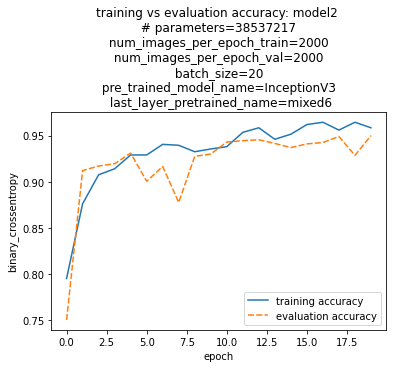

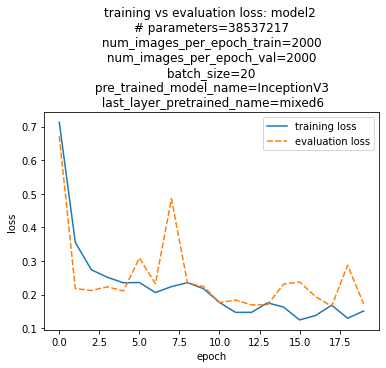

In [60]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size,
                pre_trained_model_name=pre_trained_model_name,
                last_layer_pretrained_name=last_layer_pretrained_name)

In [61]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [62]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")

Accuracy Score: 0.948
Balanced Accuracy Score: 0.948


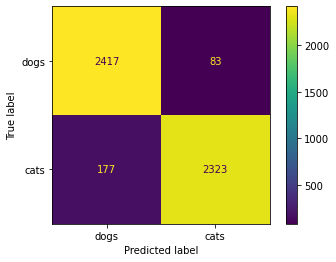

In [63]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [64]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [65]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [66]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 7.08%
Proportion of misclassified dogs: 3.32%


In [67]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats,
                  pre_trained_model_name,
                  last_layer_pretrained_name
                  ]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats,pre_trained_model_name,last_layer_pretrained_name
0,TF_CNN_TransferLearning.ipynb,model1,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,"True_Transform_All_Training_Images, Keep Same ...",0.880604,0.902075,0.7936,0.9912,0.989033,0.827655,0.2064,0.0088,InceptionV3,mixed6
1,TF_CNN_TransferLearning.ipynb,model2,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,False,0.948960,0.947004,0.9668,0.9292,0.931766,0.965503,0.0332,0.0708,InceptionV3,mixed6


In [68]:
model.save(model_name) #save model
model=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model2/assets


# 6.0 model3

In [69]:
filename='TF_CNN_TransferLearning.ipynb'
model_name='model3'
optimizer=RMSprop(lr=0.0001)
optimizer_name=str(optimizer)
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=20
img_size=150
steps_per_epoch=100
epochs=20
validation_steps=100
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=True
pre_trained_model_name='InceptionV3'
last_layer_pretrained_name='mixed6'

num_images_per_epoch_train:  2000
num_images_per_epoch_val:  2000


## Create **train_1** train & eval images

In [70]:
! rm -r /content/train_1
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Download Model

In [71]:
if pre_trained_model_name=='InceptionV3':
  pre_trained_model=tf.keras.applications.inception_v3.InceptionV3(
      input_shape=(img_size,img_size,3),
      include_top=False,
      weights="imagenet",
  )


In [72]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [73]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

## Set Last Layer to Transfer Learn from

In [74]:
print(last_layer_pretrained_name)
last_layer=pre_trained_model.get_layer(last_layer_pretrained_name)

mixed6


In [75]:
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [76]:
last_output=last_layer.output

## Add Custom Classifier Layers

In [77]:


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = optimizer, 
              loss = loss, 
              metrics = [accuracy_metric])


In [78]:
train_dir = '/content/train_1/train/'
validation_dir = '/content/train_1/eval/'
train_cats_dir='/content/train_1/train/cat/'
validation_cats_dir='/content/train_1/eval/cat/'
train_dogs_dir='/content/train_1/train/dog/'
validation_dogs_dir='/content/train_1/eval/dog/'

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
if data_augmentation=='True_Only':
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
else:
  train_datagen=ImageDataGenerator(rescale=1.0/255.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = (img_size, img_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_size, img_size))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Train Model

In [79]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = epochs,
            validation_steps = validation_steps)

Epoch 1/20
100/100 [==============================] - 14s 117ms/step - loss: 0.6999 - binary_accuracy: 0.7975 - val_loss: 0.2115 - val_binary_accuracy: 0.9155
Epoch 2/20
100/100 [==============================] - 11s 108ms/step - loss: 0.2831 - binary_accuracy: 0.8865 - val_loss: 0.2266 - val_binary_accuracy: 0.9065
Epoch 3/20
100/100 [==============================] - 11s 108ms/step - loss: 0.2745 - binary_accuracy: 0.8920 - val_loss: 0.1543 - val_binary_accuracy: 0.9340
Epoch 4/20
100/100 [==============================] - 11s 108ms/step - loss: 0.2256 - binary_accuracy: 0.9170 - val_loss: 0.1781 - val_binary_accuracy: 0.9300
Epoch 5/20
100/100 [==============================] - 11s 109ms/step - loss: 0.2306 - binary_accuracy: 0.9230 - val_loss: 0.2103 - val_binary_accuracy: 0.9245
Epoch 6/20
100/100 [==============================] - 11s 107ms/step - loss: 0.2166 - binary_accuracy: 0.9300 - val_loss: 0.2889 - val_binary_accuracy: 0.9035
Epoch 7/20
100/100 [==========================

## Evaluate **model**

In [80]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

38537217

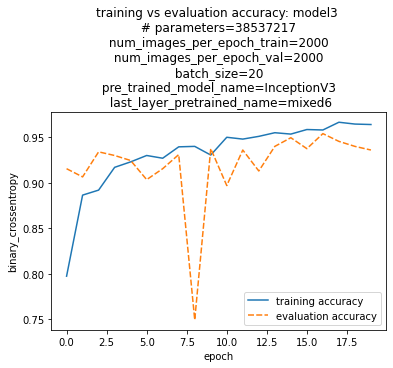

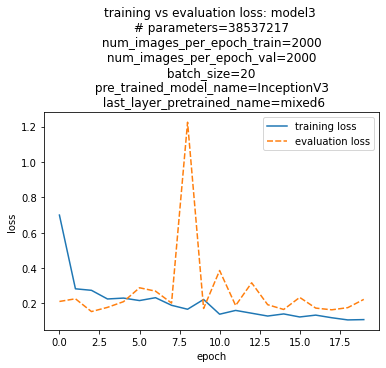

In [81]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size,
                pre_trained_model_name=pre_trained_model_name,
                last_layer_pretrained_name=last_layer_pretrained_name)

In [82]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [83]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")

Accuracy Score: 0.9414
Balanced Accuracy Score: 0.9414


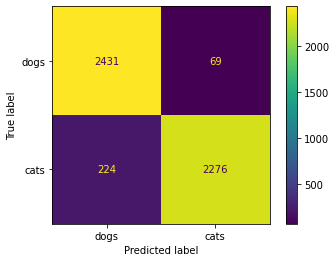

In [84]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [85]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [86]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [87]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 8.96%
Proportion of misclassified dogs: 2.76%


In [88]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats,
                  pre_trained_model_name,
                  last_layer_pretrained_name
                  ]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats,pre_trained_model_name,last_layer_pretrained_name
0,TF_CNN_TransferLearning.ipynb,model1,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,"True_Transform_All_Training_Images, Keep Same ...",0.880604,0.902075,0.7936,0.9912,0.989033,0.827655,0.2064,0.0088,InceptionV3,mixed6
1,TF_CNN_TransferLearning.ipynb,model2,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,False,0.948960,0.947004,0.9668,0.9292,0.931766,0.965503,0.0332,0.0708,InceptionV3,mixed6
2,TF_CNN_TransferLearning.ipynb,model3,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,True,0.943162,0.939525,0.9724,0.9104,0.915631,0.970576,0.0276,0.0896,InceptionV3,mixed6


In [89]:
model.save(model_name) #save model
model=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model3/assets


# 7.0 model4

In [90]:
filename='TF_CNN_TransferLearning.ipynb'
model_name='model4'
optimizer='adam'
optimizer_name=str(optimizer)
loss='binary_crossentropy'
accuracy_metric='binary_accuracy'
batch_size=20
img_size=150
steps_per_epoch=100
epochs=20
validation_steps=100
num_images_per_epoch_train=batch_size*steps_per_epoch
print('num_images_per_epoch_train: ',num_images_per_epoch_train)
num_images_per_epoch_val=batch_size*validation_steps
print('num_images_per_epoch_val: ',num_images_per_epoch_val)
data_augmentation=True
pre_trained_model_name='InceptionV3'
last_layer_pretrained_name='mixed6'

num_images_per_epoch_train:  2000
num_images_per_epoch_val:  2000


## Create **train_1** train & eval images

In [91]:
! rm -r /content/train_1
! unzip train.zip -d train
new_dir('train_1')
new_dir('train_1/train')
new_dir('train_1/eval')
new_dir('train_1/train/cat')
new_dir('train_1/train/dog')
new_dir('train_1/eval/cat')
new_dir('train_1/eval/dog')
cats=[w for w in os.listdir('train/train') if w.find('cat')!=-1]
dogs=[w for w in os.listdir('train/train') if w.find('dog')!=-1]
train_cats=list(cats)[0:int(.8*len(cats))]
eval_cats=list(cats)[int(.8*len(cats)):]

train_dogs=list(dogs)[0:int(.8*len(dogs))]
eval_dogs=list(dogs)[int(.8*len(dogs)):]
print('total cats vs. total dogs')
print(len(cats),len(dogs))

items=os.listdir('train/train')
def move_files(items,destination,source_path='/content/train/train'):
  for it in items:
      try:
        shutil.move(os.path.join(os.path.join(source_path,it)), destination)
      except:
        pass
move_files(train_cats,'/content/train_1/train/cat/')
move_files(eval_cats,'/content/train_1/eval/cat/')
move_files(train_dogs,'/content/train_1/train/dog/')
move_files(eval_dogs,'/content/train_1/eval/dog/')

Streaming output truncated to the last 5000 lines.
  inflating: train/train/dog.550.jpg  
  inflating: train/train/dog.5500.jpg  
  inflating: train/train/dog.5501.jpg  
  inflating: train/train/dog.5502.jpg  
  inflating: train/train/dog.5503.jpg  
  inflating: train/train/dog.5504.jpg  
  inflating: train/train/dog.5505.jpg  
  inflating: train/train/dog.5506.jpg  
  inflating: train/train/dog.5507.jpg  
  inflating: train/train/dog.5508.jpg  
  inflating: train/train/dog.5509.jpg  
  inflating: train/train/dog.551.jpg  
  inflating: train/train/dog.5510.jpg  
  inflating: train/train/dog.5511.jpg  
  inflating: train/train/dog.5512.jpg  
  inflating: train/train/dog.5513.jpg  
  inflating: train/train/dog.5514.jpg  
  inflating: train/train/dog.5515.jpg  
  inflating: train/train/dog.5516.jpg  
  inflating: train/train/dog.5517.jpg  
  inflating: train/train/dog.5518.jpg  
  inflating: train/train/dog.5519.jpg  
  inflating: train/train/dog.552.jpg  
  inflating: train/train/dog.552

## Download Model

In [92]:
if pre_trained_model_name=='InceptionV3':
  pre_trained_model=tf.keras.applications.inception_v3.InceptionV3(
      input_shape=(img_size,img_size,3),
      include_top=False,
      weights="imagenet",
  )


In [93]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [94]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

## Set Last Layer to Transfer Learn from

In [95]:
print(last_layer_pretrained_name)
last_layer=pre_trained_model.get_layer(last_layer_pretrained_name)

mixed6


In [96]:
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 7, 7, 768)


In [97]:
last_output=last_layer.output

## Add Custom Classifier Layers

In [98]:


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = optimizer, 
              loss = loss, 
              metrics = [accuracy_metric])


In [99]:
train_dir = '/content/train_1/train/'
validation_dir = '/content/train_1/eval/'
train_cats_dir='/content/train_1/train/cat/'
validation_cats_dir='/content/train_1/eval/cat/'
train_dogs_dir='/content/train_1/train/dog/'
validation_dogs_dir='/content/train_1/eval/dog/'

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
if data_augmentation=='True_Only':
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)
else:
  train_datagen=ImageDataGenerator(rescale=1.0/255.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = (img_size, img_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_size, img_size))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Train Model

In [100]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = epochs,
            validation_steps = validation_steps)

Epoch 1/20
100/100 [==============================] - 15s 129ms/step - loss: 1.8146 - binary_accuracy: 0.8230 - val_loss: 0.2324 - val_binary_accuracy: 0.9080
Epoch 2/20
100/100 [==============================] - 11s 112ms/step - loss: 0.2403 - binary_accuracy: 0.9155 - val_loss: 0.1586 - val_binary_accuracy: 0.9355
Epoch 3/20
100/100 [==============================] - 11s 111ms/step - loss: 0.1817 - binary_accuracy: 0.9250 - val_loss: 0.1777 - val_binary_accuracy: 0.9305
Epoch 4/20
100/100 [==============================] - 11s 107ms/step - loss: 0.1901 - binary_accuracy: 0.9190 - val_loss: 0.1517 - val_binary_accuracy: 0.9310
Epoch 5/20
100/100 [==============================] - 11s 108ms/step - loss: 0.1623 - binary_accuracy: 0.9395 - val_loss: 0.1644 - val_binary_accuracy: 0.9335
Epoch 6/20
100/100 [==============================] - 11s 108ms/step - loss: 0.1553 - binary_accuracy: 0.9340 - val_loss: 0.2271 - val_binary_accuracy: 0.9070
Epoch 7/20
100/100 [==========================

## Evaluate **model**

In [101]:
trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
trainableParams

38537217

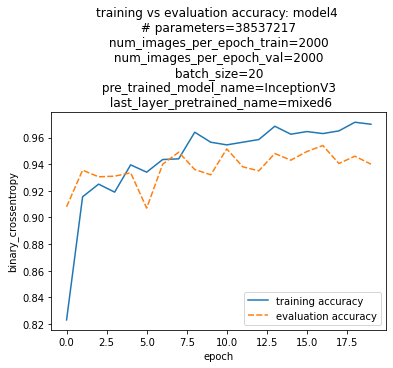

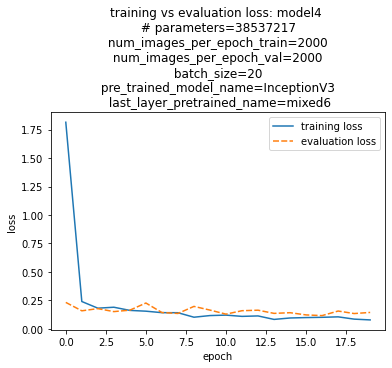

In [102]:
plot_train_eval(history,name=model_name,parameters=str(trainableParams),
                num_images_per_epoch_train=num_images_per_epoch_train,
                num_images_per_epoch_val=num_images_per_epoch_val,
                batch_size=batch_size,
                pre_trained_model_name=pre_trained_model_name,
                last_layer_pretrained_name=last_layer_pretrained_name)

In [103]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/content/train_1/eval',
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 5000 images belonging to 2 classes.


In [104]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions= model.predict(val_gen_no_shuffle)
y_pred=np.where(predictions>0.5,1,0)



accuracy_score_i=accuracy_score(y_true, y_pred)
# Print accuracy score
print(f"Accuracy Score: {accuracy_score_i}")

# Print balanced accuracy score
balanced_accuracy_score_i=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy Score: {balanced_accuracy_score_i}")

Accuracy Score: 0.9464
Balanced Accuracy Score: 0.9464


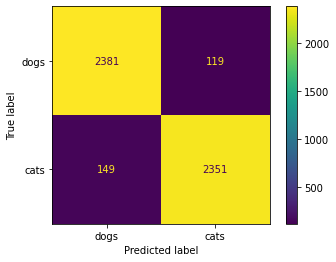

In [105]:
cm = confusion_matrix(y_true, y_pred)
conf_matrix_i=ConfusionMatrixDisplay(cm, display_labels=['dogs', 'cats']).plot(values_format="d")

In [106]:
conf_matrix_i.figure_.savefig(f'Confusion_Matrix_for_{model_name}.jpg')

In [107]:
TP_dog=cm[0,0]
FN_dog=cm[0,1]
FP_dog=cm[1,0]
Precision_dog=TP_dog/(TP_dog+FN_dog)
Recall_dog=TP_dog/(TP_dog+FP_dog)
F1_score_dog=2*Precision_dog*Recall_dog/(Precision_dog+Recall_dog)

TP_cat=cm[1,1]
FN_cat=cm[1,0]
FP_cat=cm[0,1]
Precision_cat=TP_cat/(TP_cat+FN_cat)
Recall_cat=TP_cat/(TP_cat+FP_cat)
F1_score_cat=2*Precision_cat*Recall_cat/(Precision_cat+Recall_cat)

In [108]:
misclassified_dogs = (cm[0,1])/np.sum(cm, axis=1)[0]
misclassified_cats = (cm[1,0])/np.sum(cm, axis=1)[1]
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified cats: 5.96%
Proportion of misclassified dogs: 4.76%


In [109]:
df=pd.DataFrame([[filename,model_name,
                  optimizer,
                  loss,
                  accuracy_metric,
                  batch_size,img_size,steps_per_epoch,epochs,validation_steps,
                  num_images_per_epoch_train,num_images_per_epoch_val,
                  data_augmentation,
                  F1_score_dog,F1_score_cat,
                  Precision_dog,Precision_cat,
                  Recall_dog,Recall_cat,
                  misclassified_dogs,misclassified_cats,
                  pre_trained_model_name,
                  last_layer_pretrained_name
                  ]],columns=cols)
df_metrics=df_metrics.append(df,ignore_index=True)
df_metrics

,filename,model_name,optimizer,loss,accuracy_metric,batch_size,img_size,steps_per_epoch,epochs,validation_steps,num_images_per_epoch_train,num_images_per_epoch_val,data_augmentation,F1_score_dog,F1_score_cat,Precision_dog,Precision_cat,Recall_dog,Recall_cat,misclassified_dogs,misclassified_cats,pre_trained_model_name,last_layer_pretrained_name
0,TF_CNN_TransferLearning.ipynb,model1,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,"True_Transform_All_Training_Images, Keep Same ...",0.880604,0.902075,0.7936,0.9912,0.989033,0.827655,0.2064,0.0088,InceptionV3,mixed6
1,TF_CNN_TransferLearning.ipynb,model2,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,False,0.948960,0.947004,0.9668,0.9292,0.931766,0.965503,0.0332,0.0708,InceptionV3,mixed6
2,TF_CNN_TransferLearning.ipynb,model3,<tensorflow.python.keras.optimizer_v2.rmsprop....,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,True,0.943162,0.939525,0.9724,0.9104,0.915631,0.970576,0.0276,0.0896,InceptionV3,mixed6
3,TF_CNN_TransferLearning.ipynb,model4,adam,binary_crossentropy,binary_accuracy,20,150,100,20,100,2000,2000,True,0.946720,0.946076,0.9524,0.9404,0.941107,0.951822,0.0476,0.0596,InceptionV3,mixed6


In [110]:
model.save(model_name) #save model
model=tf.keras.models.load_model(model_name) #load model
df_metrics.to_excel('df_metrics.xlsx')

INFO:tensorflow:Assets written to: model4/assets
